# Import

In [12]:
import sys

root_dir = '../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets, distributions

# Dataset

In [2]:
dataset = datasets.ML20m()
n_user = dataset.n_user
n_item = dataset.n_item
train_set, test_set = dataset.get_train_and_test_set()

# device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.LongTensor(test_set).to(device)

# Evaluator

In [3]:
# k
ks = [10]

recall = evaluators.RecallEvaluator(test_set, ks)
unpopularity = evaluators.UnpopularityEvaluator(test_set, ks)
f1_score = evaluators.F1ScoreEvaluator(test_set, ks)
# coverage = evaluators.CoverageEvaluator(test_set, ks)
# hubness = evaluators.HubnessEvaluator(test_set, ks)

# Sampler

In [4]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [5]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# No Training Result

In [6]:
knn = searches.NearestNeighborhood(model)
trainer.valid(knn, recall)
display(trainer.valid_scores)

,Recall@10
0,0.12595


# Training

In [7]:
# only traing no validation
trainer.fit(n_batch, n_epoch)

# Result

## Base CML

In [8]:
knn = searches.NearestNeighborhood(model)

# Recall
trainer.valid(knn, recall)
base_recall = trainer.valid_scores.copy()
display(base_recall)

# Unpopularity
trainer.valid(knn, unpopularity)
base_unpopularity = trainer.valid_scores.copy()
display(base_unpopularity)

# F1-score
trainer.valid(knn, f1_score)
base_f1_score = trainer.valid_scores.copy()
display(base_f1_score)

,Recall@10
0,0.485454


,Unpopularity@10
0,0.042541


,F1-score@10
0,0.06812


## CML+MP

In [9]:
search_ranges = [10, 15, 20, 25, 30, 35, 40]

### Recall

In [10]:
re_recall = []
for search_range in search_ranges:
    print(f'search_range={search_range}')
    mp = searches.Mymp(model, search_range)
    trainer.valid(mp, recall)
    re = trainer.valid_scores.copy()
    display(re)
    re_recall.append(re.iloc[-1, 0])

search_range=10


,Recall@10
0,0.454352


search_range=15


,Recall@10
0,0.412919


search_range=20


,Recall@10
0,0.32897


search_range=25


,Recall@10
0,0.271376


search_range=30


,Recall@10
0,0.232011


search_range=35


,Recall@10
0,0.203501


search_range=40


,Recall@10
0,0.183033


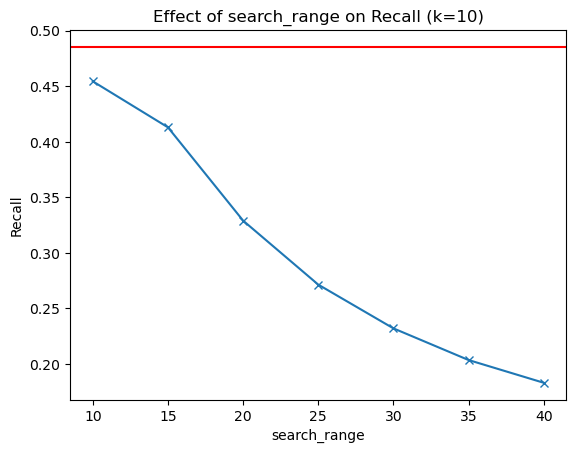

In [13]:
plt.plot(search_ranges, re_recall, marker='x')
plt.title('Effect of search_range on Recall (k=10)')
plt.xlabel('search_range')
plt.ylabel('Recall')
plt.xticks(search_ranges)
plt.axhline(y=base_recall.iloc[-1, 0], color='r', linestyle='-')
plt.show()

### Unpopularity

In [14]:
re_unpopularity = []
for search_range in search_ranges:
    print(f'search_range={search_range}')
    mp = searches.Mymp(model, search_range)
    trainer.valid(mp, unpopularity)
    re = trainer.valid_scores.copy()
    display(re)
    re_unpopularity.append(re.iloc[-1, 0])

search_range=10


KeyboardInterrupt: 

In [ ]:
plt.plot(search_ranges, re_unpopularity, marker='x')
plt.title('Effect of search_range on Unpopularity (k=10)')
plt.xlabel('search_range')
plt.ylabel('Unpopularity')
plt.xticks(search_ranges)
plt.axhline(y=base_unpopularity.iloc[-1, 0], color='r', linestyle='-')
plt.show()

### F1-score

In [ ]:
re_f1_score = []
for search_range in search_ranges:
    print(f'search_range={search_range}')
    mp = searches.Mymp(model, search_range)
    trainer.valid(mp, f1_score)
    re = trainer.valid_scores.copy()
    display(re)
    re_f1_score.append(re.iloc[-1, 0])

In [ ]:
plt.plot(search_ranges, re_f1_score, marker='x')
plt.title('Effect of search_range on F1-score (k=10)')
plt.xlabel('search_range')
plt.ylabel('F1-score')
plt.xticks(search_ranges)
plt.axhline(y=base_f1_score.iloc[-1, 0], color='r', linestyle='-')
plt.show()